# Clustering with hawkes processes

In [1]:
import pandas as pd

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('GAZPRU.csv', parse_dates=['TradeDateTime'], index_col='TradeDateTime')

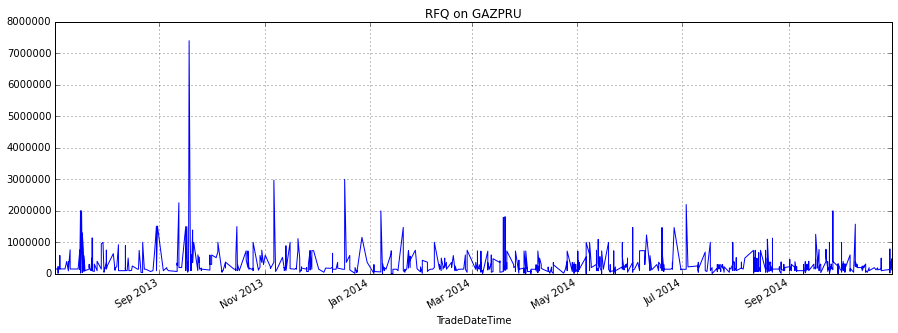

In [3]:
df['NotionalEUR'].plot(figsize=(15,5), title = 'RFQ on GAZPRU')

In [4]:
from hawkes.hawkes import GetTimeSeriesFromCSV, ExpectationMaximization, Q, GetLeadersFollowers

In [5]:
time = GetTimeSeriesFromCSV('GAZPRU.csv', nbpoints=1000)

In [6]:
def inspect(verbose=False):
    it = [0]
    QQ = []
    def inspectclosed(mu, a, b, t, p, dt, T, S0, S1, S2):
        it[0] += 1
        q = Q(mu, a, b, t, p, dt)
        QQ.append(q)
        if it[0] == 1 or it[0] % 10 == 0:
            print ("iter = %s: (mu, a, b) = (%.2f, %.2f, %.2f)" % (it[0], mu, a, b)).ljust(35),
            print "Q = %s" % q
    inspectclosed.QQ = QQ
    return inspectclosed
        
inspector = inspect(verbose=False)
mu, a, b, p = ExpectationMaximization(time, niter=100, callback=inspector)

iter = 1: (mu, a, b) = (8.54, 3.35, 1.30) Q = -95.9567518707
iter = 10: (mu, a, b) = (167.69, 5.78, 5.14) Q = 1013.536287
iter = 20: (mu, a, b) = (311.52, 6.32, 7.42) Q = 2081.55899302
iter = 30: (mu, a, b) = (372.50, 7.27, 9.84) Q = 2658.20046661
iter = 40: (mu, a, b) = (387.09, 9.32, 13.47) Q = 2996.2090951
iter = 50: (mu, a, b) = (374.17, 13.22, 19.41) Q = 3225.22616468
iter = 60: (mu, a, b) = (344.40, 20.38, 29.39) Q = 3407.92425315
iter = 70: (mu, a, b) = (306.57, 33.88, 47.19) Q = 3608.14789457
iter = 80: (mu, a, b) = (269.22, 63.43, 85.05) Q = 3937.86063237
iter = 90: (mu, a, b) = (245.57, 163.68, 214.55) Q = 4698.62058795
iter = 100: (mu, a, b) = (319.27, 21077.04, 30804.57) Q = 10117.8680305


In [7]:
dict_leaders_followers = GetLeadersFollowers(p)
jump_ind = 99
leader = dict_leaders_followers[jump_ind]["leader"]
followers = dict_leaders_followers[jump_ind]["followers"]
print('Example: jump number {} has {} for leader; and {} for followers'.format(jump_ind, leader, followers))

Example: jump number 99 has [98] for leader; and [] for followers


In [8]:
nb_leaders = 0
nb_jumps = 0
for key, val in dict_leaders_followers.items():
    nb_jumps +=1
    nb_followers = len(val["followers"])
    if nb_followers > 1:
        print('Jump {} has {} for followers'.format(key, val["followers"]))
    if key == val["leader"][0]:
        #print('{} is a leader'.format(key)) 
        nb_leaders +=1
print('there are {} leaders among the {} jumps'.format(nb_leaders, nb_jumps))

Jump 23 has [24, 25] for followers
Jump 50 has [51, 52] for followers
Jump 151 has [152, 153, 154] for followers
Jump 229 has [230, 231, 232] for followers
Jump 891 has [892, 893, 894, 895] for followers
there are 292 leaders among the 1000 jumps


{'followers': [4], 'leader': [2]}

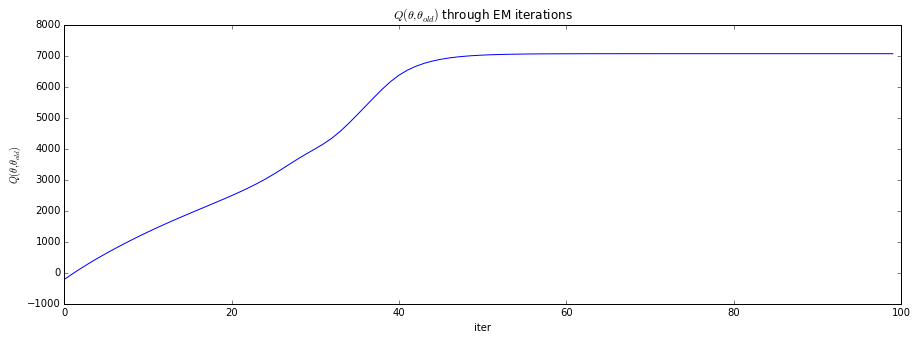

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(inspector.QQ)
plt.title(r"$Q(\theta, \theta_{old})$ through EM iterations")
plt.xlabel(r"iter")
plt.ylabel(r"$Q(\theta, \theta_{old})$")
plt.show()

## Create GAZPRU.csv

In [2]:
import pandas as pd
#filename_path = '/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv'
filename_path = '/Users/lecueguillaume/Documents/bnpp/bnpp_donnees/ETSAnonymousPricesFull.csv'
df = pd.read_csv(filename_path, parse_dates=['TradeDateTime'], index_col='TradeDateTime')

In [3]:
df2 = df[df["BuySell"] == "Buy"]
df3 = df2[df2["Ticker"] == "GAZPRU"]

In [4]:
df3.to_csv("GAZPRU.csv")